In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2022-07-01"),
    helpers.date_to_timestamp("2025-08-25"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/jesse/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


(1657440, 6)

In [2]:
np.save("data/btc_1m.npy", candles)
del candles

(1657440, 6)

In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(1657440, 6)

In [2]:
def process_sign_sequence(df, column_name, output_column=None, shift_num=-1):
    if output_column is None:
        output_column = f"{column_name}_processed"

    ### 创建掩码判断当前值和下一个值的符号关系
    same_sign = (df[column_name] * df[column_name].shift(-1) > 0) & (~df[column_name].shift(shift_num).isna())
    diff_sign = (df[column_name] * df[column_name].shift(-1) < 0) & (~df[column_name].shift(shift_num).isna())


    df[output_column] = df[column_name].copy()

    ### 处理当前值和下一个值符号相同的情况（当前值变为正数）
    df.loc[same_sign, output_column] = df.loc[same_sign, column_name].abs()

    ### 处理当前值和下一个值符号不同的情况（当前值变为负数）
    df.loc[diff_sign, output_column] = -df.loc[diff_sign, column_name].abs()

    return df

# Time bar

In [3]:
from jesse.utils import numpy_candles_to_dataframe

bars = numpy_candles_to_dataframe(candles)
bars.set_index("date", inplace=True)
bars.head()

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/jesse/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


,open,close,high,low,volume
date,,,,,
2022-07-01 00:00:00,19923.3,19794.8,19958.4,19790.0,3846.040
2022-07-01 00:01:00,19795.5,19821.1,19828.1,19753.4,2918.726
2022-07-01 00:02:00,19820.9,19745.1,19848.0,19740.3,2299.853
2022-07-01 00:03:00,19745.2,19734.9,19780.3,19733.0,1780.088
2022-07-01 00:04:00,19734.9,19708.9,19737.2,19668.5,3463.708


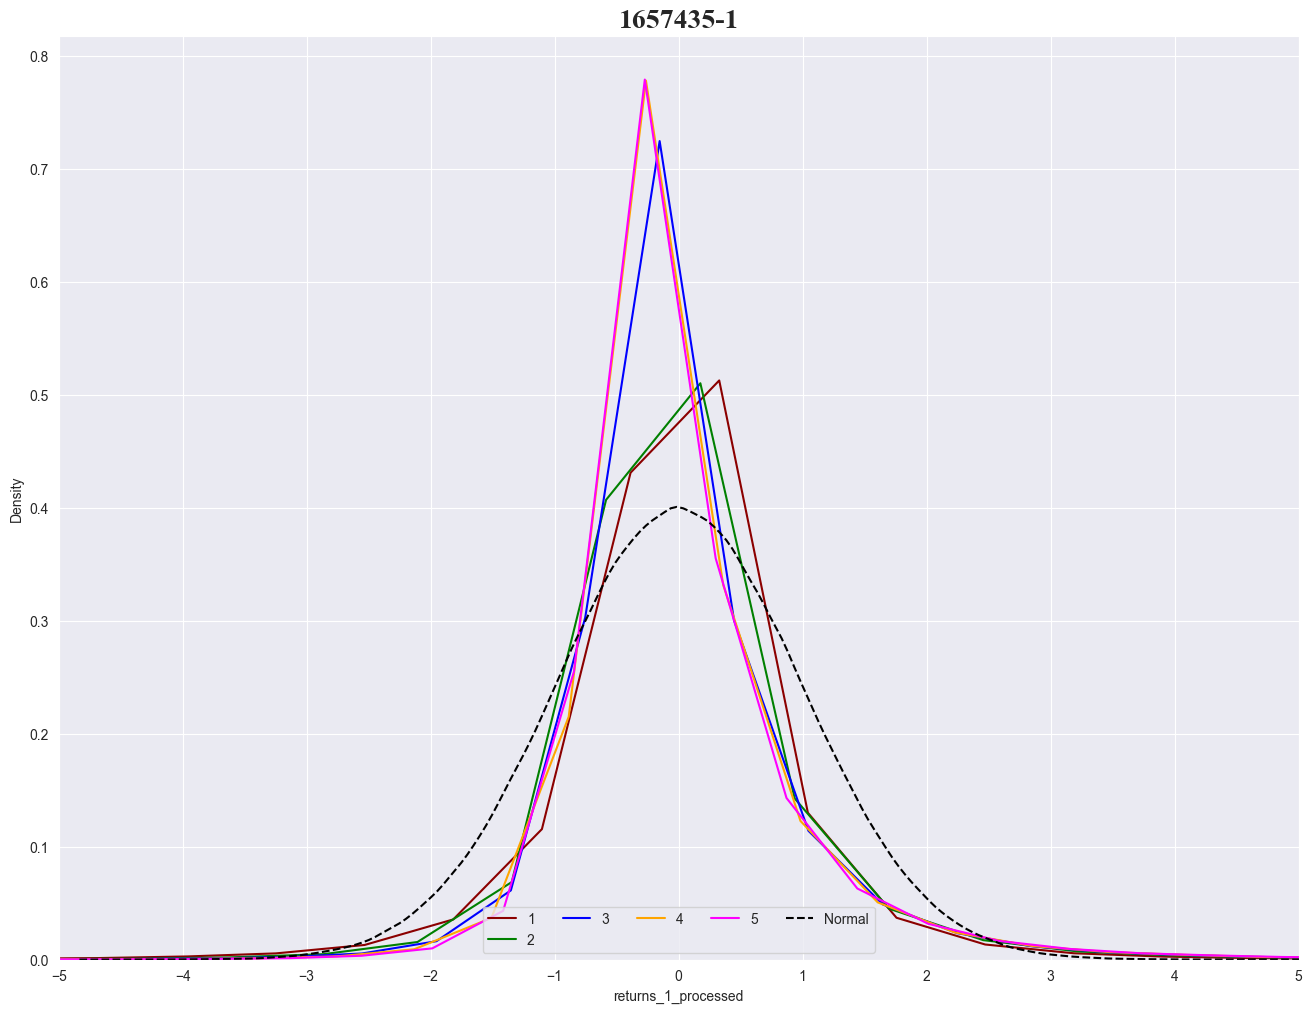

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bars['returns_1'] = np.log(bars['close']).diff().dropna()           ##############  一阶差分，同时删除缺失值  ###############
bars['returns_2'] = np.log(bars['close']).diff(periods=2).dropna()
bars['returns_3'] = np.log(bars['close']).diff(periods=3).dropna()
bars['returns_4'] = np.log(bars['close']).diff(periods=4).dropna()
bars['returns_5'] = np.log(bars['close']).diff(periods=5).dropna()

shift_num = 1

process_sign_sequence(bars, 'returns_1', shift_num=shift_num)
process_sign_sequence(bars, 'returns_2', shift_num=shift_num)
process_sign_sequence(bars, 'returns_3', shift_num=shift_num)
process_sign_sequence(bars, 'returns_4', shift_num=shift_num)
process_sign_sequence(bars, 'returns_5', shift_num=shift_num)


bars.dropna(inplace=True)


standard_1 = (bars['returns_1_processed'] - bars['returns_1_processed'].mean()) / bars['returns_1_processed'].std()
standard_2 = (bars['returns_2_processed'] - bars['returns_2_processed'].mean()) / bars['returns_2_processed'].std()
standard_3 = (bars['returns_3_processed'] - bars['returns_3_processed'].mean()) / bars['returns_3_processed'].std()
standard_4 = (bars['returns_4_processed'] - bars['returns_4_processed'].mean()) / bars['returns_4_processed'].std()
standard_5 = (bars['returns_5_processed'] - bars['returns_5_processed'].mean()) / bars['returns_5_processed'].std()


plt.figure(figsize=(16, 12))

sns.kdeplot(standard_1, label="1", color='darkred')
sns.kdeplot(standard_2, label="2", color='green')
sns.kdeplot(standard_3, label="3", color='blue')
sns.kdeplot(standard_4, label="4", color='orange')
sns.kdeplot(standard_5, label="5", color='magenta')

sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title(str(len(bars)) + "-1", loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.grid(True)

plt.show()

# fusion bar

In [5]:
from src.bars.fusion.deap_v1 import DeapBarV1

bar_container = DeapBarV1()
bar_container.update_with_candles(candles)
merged_candles = bar_container.get_fusion_bars()
merged_candles.shape

(5789, 6)

In [6]:
bars = numpy_candles_to_dataframe(merged_candles)
bars.set_index("date", inplace=True)
bars.head()

,open,close,high,low,volume
date,,,,,
2022-07-01 07:40:00,19575.0,19581.4,19665.9,19303.0,106594.061
2022-07-01 10:38:00,19581.3,19224.0,19794.8,19177.6,99813.741
2022-07-01 11:06:00,19223.9,19139.2,19224.7,18948.8,43096.567
2022-07-01 13:14:00,19139.2,19310.0,19370.7,19083.3,61894.000
2022-07-01 17:41:00,19309.9,19466.7,19666.0,19188.4,176359.023


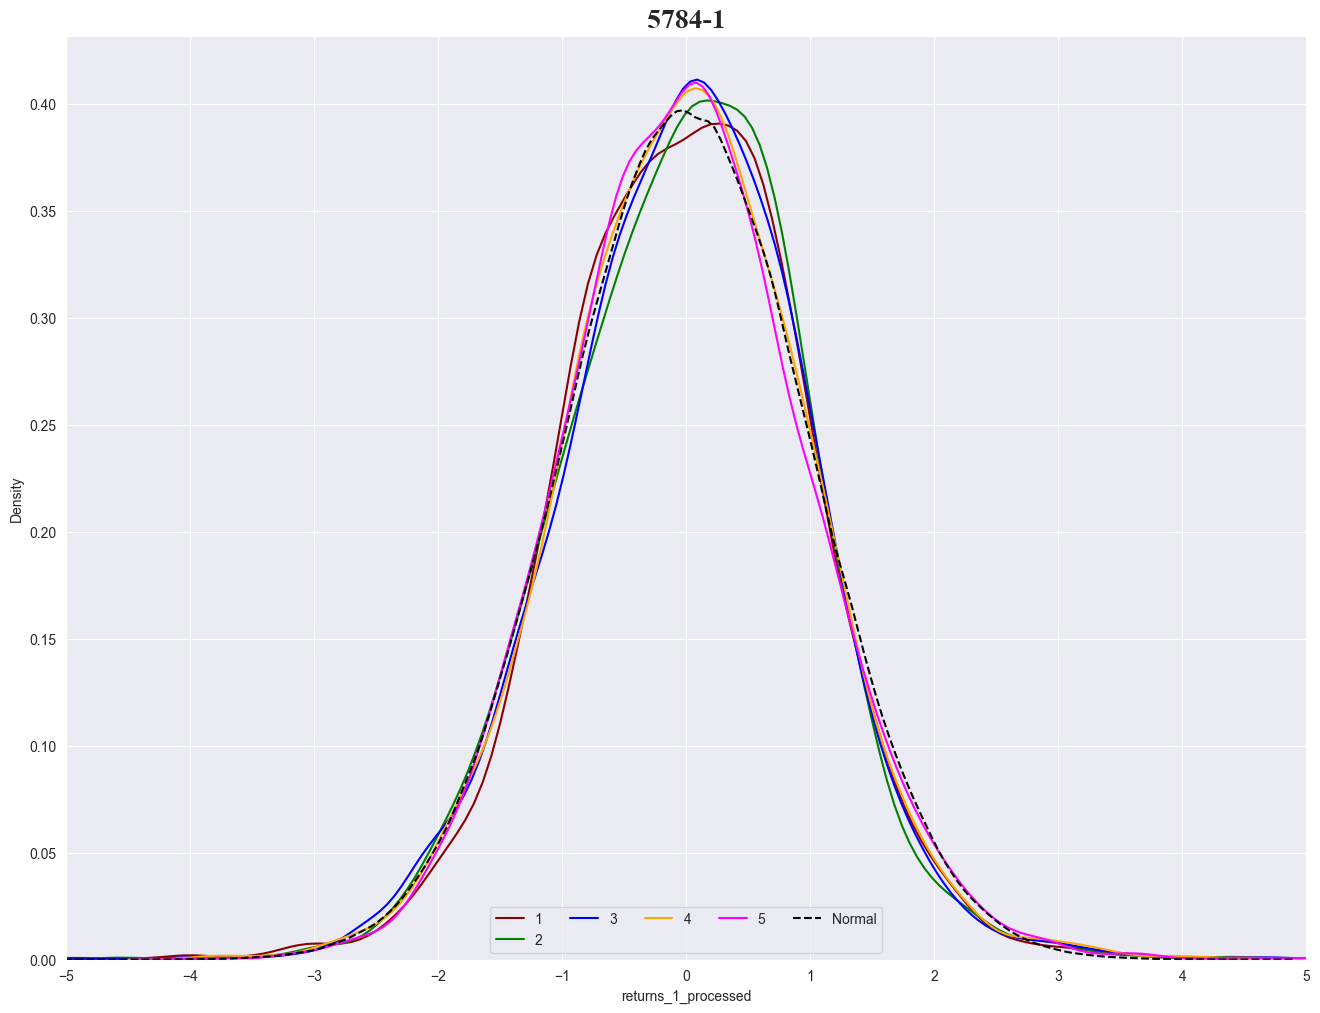

In [7]:
bars['returns_1'] = np.log(bars['close']).diff().dropna()           ##############  一阶差分，同时删除缺失值  ###############
bars['returns_2'] = np.log(bars['close']).diff(periods=2).dropna()
bars['returns_3'] = np.log(bars['close']).diff(periods=3).dropna()
bars['returns_4'] = np.log(bars['close']).diff(periods=4).dropna()
bars['returns_5'] = np.log(bars['close']).diff(periods=5).dropna()

shift_num = 1

process_sign_sequence(bars, 'returns_1', shift_num=shift_num)
process_sign_sequence(bars, 'returns_2', shift_num=shift_num)
process_sign_sequence(bars, 'returns_3', shift_num=shift_num)
process_sign_sequence(bars, 'returns_4', shift_num=shift_num)
process_sign_sequence(bars, 'returns_5', shift_num=shift_num)


bars.dropna(inplace=True)


standard_1 = (bars['returns_1_processed'] - bars['returns_1_processed'].mean()) / bars['returns_1_processed'].std()
standard_2 = (bars['returns_2_processed'] - bars['returns_2_processed'].mean()) / bars['returns_2_processed'].std()
standard_3 = (bars['returns_3_processed'] - bars['returns_3_processed'].mean()) / bars['returns_3_processed'].std()
standard_4 = (bars['returns_4_processed'] - bars['returns_4_processed'].mean()) / bars['returns_4_processed'].std()
standard_5 = (bars['returns_5_processed'] - bars['returns_5_processed'].mean()) / bars['returns_5_processed'].std()


plt.figure(figsize=(16, 12))

sns.kdeplot(standard_1, label="1", color='darkred')
sns.kdeplot(standard_2, label="2", color='green')
sns.kdeplot(standard_3, label="3", color='blue')
sns.kdeplot(standard_4, label="4", color='orange')
sns.kdeplot(standard_5, label="5", color='magenta')

sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title(str(len(bars)) + "-1", loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.grid(True)

plt.show()